In [34]:
# Import Libraries
import pandas as pd
import numpy as np
import torch
from datasets import Dataset
import warnings
import re
import string
from ftfy import fix_text
from langdetect import detect, LangDetectException
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedShuffleSplit
import torch.nn.functional as F
from transformers import get_linear_schedule_with_warmup

from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader
from torch import nn
from torch.optim import AdamW
from tqdm.auto import tqdm
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, 
                             confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Ignore Warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [35]:
# Check cuda status
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


## Data Loading and Preparation

### Prepare dataset

In [36]:
# Load data from CSV files
df = pd.read_csv('source data/scraped_tweets.csv')
df_main = pd.read_csv("cleaned data/cleaned_data_split.csv", index_col=0)
df_main['Handle'] = '@' + df_main['screen_name']

# Merge datasets on Twitter handle
result = df.merge(df_main, on='Handle', how='inner')

# Remove duplicates based on unique identifier 'Handle'
result = result.drop_duplicates(subset=['Handle'])

# Replace NaN values in specific columns with 'NA'
result.fillna({'Content': 'NA', 'description': 'NA'}, inplace=True)

# Fix text encoding issues in 'Content' and 'description' columns
result['Content'] = result['Content'].apply(fix_text)
result['description'] = result['description'].apply(fix_text)


### Data Cleaning

In [37]:
# Define language detection function to filter English-only content
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False  # Mark as non-English if detection fails

# Filter rows where 'Content' is in English only
result_final = result[result['Content'].apply(is_english)]

# Optional: Save cleaned and filtered data to a new CSV file
# result_final.to_csv("cleaned_data_content_english_only.csv", index=False, encoding='utf-8')

print("Cleaned and filtered data (English-only for 'Content') has been saved as 'cleaned_data_content_english_only.csv'.")

Cleaned and filtered data (English-only for 'Content') has been saved as 'cleaned_data_content_english_only.csv'.


In [38]:
# Text cleaning for Content column
def clean_text(text):
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    text = text.lower()  # Convert to lowercase for uncased model
    text = text.translate(str.maketrans('', '', string.punctuation))  # Optionally remove punctuation
    return text

result_final['cleaned_content'] = result_final['Content'].apply(clean_text)

C:\Users\USER\AppData\Local\Temp\ipykernel_7048\1234352611.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_final['cleaned_content'] = result_final['Content'].apply(clean_text)


### Data Preprocessing and Stratified Splitting

In [39]:
# Load pretrained BERT tokenizer for processing input text
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Convert cleaned DataFrame to Hugging Face Dataset format
result_final = result_final[['cleaned_content', 'account_type']].reset_index(drop=True)
dataset = Dataset.from_pandas(result_final)

# Convert Hugging Face Dataset back to pandas DataFrame for stratified split usage
df = dataset.to_pandas()

# Separate features and target label
X = df.drop(columns=["account_type"])
y = df["account_type"]

# Perform first split: 60% training and 40% temporary set for further division
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_index, temp_index = next(sss.split(X, y))
train_df = df.iloc[train_index]
temp_df = df.iloc[temp_index]

# Split temporary set: 50% validation and 50% test
sss_temp = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_index, test_index = next(sss_temp.split(temp_df.drop(columns=["account_type"]), temp_df["account_type"]))
val_df = temp_df.iloc[val_index]
test_df = temp_df.iloc[test_index]

# Convert DataFrames back to Hugging Face Dataset format for compatibility with transformers
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)


In [40]:
# Check max content length for padding
content_length = result_final['cleaned_content'].apply(lambda x: len(str(x).split()))
max_content_len = max(content_length)

print("Max length of content is: ", max_content_len)

Max length of content is:  57


### Tokenization

In [41]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["cleaned_content"], padding="max_length", truncation=True, max_length=max_content_len)

# Apply tokenization to training, validation, and test datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Rename 'account_type' column to 'labels' to align with model's expected input format
tokenized_train = tokenized_train.rename_column("account_type", "labels")
tokenized_val = tokenized_val.rename_column("account_type", "labels")
tokenized_test = tokenized_test.rename_column("account_type", "labels")

# Remove unnecessary columns (e.g., 'cleaned_content') from datasets
tokenized_train = tokenized_train.remove_columns(["cleaned_content"])
tokenized_val = tokenized_val.remove_columns(["cleaned_content"])
tokenized_test = tokenized_test.remove_columns(["cleaned_content"])

# Set data format for PyTorch model input with 'input_ids', 'attention_mask', and 'labels'
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Combine datasets into a DatasetDict for easy access during training and evaluation
tokenized_datasets = DatasetDict({
    "train": tokenized_train,
    "validation": tokenized_val,
    "test": tokenized_test
})

# Display structure of the final DatasetDict to confirm format
print(tokenized_datasets)

Map:   0%|          | 0/1093 [00:00<?, ? examples/s]

Map:   0%|          | 0/364 [00:00<?, ? examples/s]

Map:   0%|          | 0/365 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1093
    })
    validation: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 364
    })
    test: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 365
    })
})


### Create DataLoader

In [42]:
# Set batch size for data loading
batch_size = 25

# Create DataLoaders for training, validation, and test sets
# DataLoaders handle batching and shuffling for efficient model training and evaluation
train_dataloader = DataLoader(tokenized_train, shuffle=True, batch_size=batch_size)  # Shuffle for training
val_dataloader = DataLoader(tokenized_val, batch_size=batch_size)  # No shuffle for validation
test_dataloader = DataLoader(tokenized_test, batch_size=batch_size)  # No shuffle for testing


## Model Structure

### Define Model Architecture

In [43]:
from transformers import AutoModelForSequenceClassification

class Model(nn.Module):
    def __init__(self, output_dim, dropout_rate):
        super(Model, self).__init__()
        
        # Initialize BERT encoder with output hidden states for further processing
        self.encoder = AutoModelForSequenceClassification.from_pretrained(
            "bert-base-uncased", output_hidden_states=True, return_dict=True
        )
        
        # Additional layers: dropout, layer normalization, and custom classifier
        self.dropout = nn.Dropout(dropout_rate)
        self.layer_norm = nn.LayerNorm(3072)  # Normalization layer
        self.classifier = nn.Linear(3072, output_dim)  # Classification layer

    def mean_pooling(self, token_embeddings, attention_mask):
        # Perform mean pooling on token embeddings, accounting for attention mask
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

    def forward(self, input_ids, token_type_ids=None, attention_mask=None):
        # Forward pass through BERT encoder to get hidden states
        outputs = self.encoder(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        
        # Concatenate the last four hidden layers for enhanced contextual representation
        hidden_states = torch.cat([outputs.hidden_states[i] for i in [-1, -2, -3, -4]], dim=-1)

        # Apply layer normalization for stable training
        hidden_states = self.layer_norm(hidden_states)

        # Use mean pooling to aggregate token embeddings
        pooled_output = self.mean_pooling(hidden_states, attention_mask)

        # Pass through dropout and then classification layer
        x = self.dropout(pooled_output)
        x = self.classifier(x)
        return x

### Loss Function and Optimizer Setup

In [44]:
# Initialize the custom model with specified output dimensions and dropout rate
model = Model(output_dim=2, dropout_rate=0.5)

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to the appropriate device

# Calculate class weights to address potential class imbalance
labels = result_final['account_type'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define custom Focal Loss class to handle class imbalance by emphasizing hard-to-classify samples
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, class_weights=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Scaling factor for loss
        self.gamma = gamma  # Modulates the effect of easy vs. hard samples
        self.class_weights = class_weights  # Optional weights for class imbalance

    def forward(self, inputs, targets):
        # Compute Cross-Entropy Loss, weighted by class weights
        BCE_loss = F.cross_entropy(inputs, targets, weight=self.class_weights, reduction='none')
        pt = torch.exp(-BCE_loss)  # Model's predicted probability for true class
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss  # Focal Loss formula
        return torch.mean(F_loss)

# Initialize the Focal Loss function with computed class weights
loss_fct = FocalLoss(alpha=1, gamma=2, class_weights=class_weights)

# Set up the optimizer with AdamW and a learning rate suitable for fine-tuning BERT
optimizer = AdamW(model.parameters(), lr=1e-4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
epochs = 5

# Calculate the total number of training steps for the scheduler
num_training_steps = epochs * len(train_dataloader)

# Reinitialize the optimizer with a learning rate suitable for fine-tuning BERT
optimizer = AdamW(model.parameters(), lr=2e-5)

# Set up a linear learning rate scheduler with warmup
# Warmup steps are set to 10% of the total training steps to gradually increase the learning rate at the start
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=int(0.1 * num_training_steps), 
    num_training_steps=num_training_steps
)

### Training and Validation Loop

In [46]:
progress_bar = tqdm(range(num_training_steps))

for epoch in range(epochs):
    # Training Phase
    model.train()  # Set model to training mode
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}  # Move batch to the appropriate device
        label_ids = batch['labels']
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']

        # Forward pass to compute logits
        logits = model(input_ids, attention_mask=attention_mask)

        # Calculate loss using Focal Loss for improved handling of class imbalance
        loss = loss_fct(logits, label_ids)

        # Backward pass for gradient calculation and optimization
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update model parameters and learning rate schedule
        optimizer.step()
        scheduler.step()  # Adjust learning rate
        optimizer.zero_grad()  # Reset gradients
        progress_bar.update(1)  # Update progress bar

    # Validation Phase (run after each epoch to evaluate model performance)
    model.eval()  # Set model to evaluation mode
    all_true_labels = []
    all_predictions = []
    total_val_loss = 0
    num_batches = 0

    # No gradient calculation needed in evaluation
    with torch.no_grad():
        for batch in val_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            label_ids = batch['labels']
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            # Forward pass to compute validation logits
            logits = model(input_ids, attention_mask=attention_mask)

            # Calculate validation loss
            loss = loss_fct(logits, label_ids)
            total_val_loss += loss.item()
            num_batches += 1

            # Collect predictions and true labels for metrics calculation
            preds = torch.argmax(logits, dim=-1)
            all_true_labels.extend(label_ids.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())

    # Calculate and display validation metrics for the epoch
    avg_val_loss = total_val_loss / num_batches
    accuracy = accuracy_score(all_true_labels, all_predictions)
    f1 = f1_score(all_true_labels, all_predictions, average='weighted')
    print(f"Epoch {epoch + 1}: Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

  0%|          | 0/220 [00:00<?, ?it/s]

Epoch 1: Validation Loss: 0.2028, Accuracy: 0.6511, F1 Score: 0.6758
Epoch 2: Validation Loss: 0.1899, Accuracy: 0.6181, F1 Score: 0.6460
Epoch 3: Validation Loss: 0.1958, Accuracy: 0.5989, F1 Score: 0.6263
Epoch 4: Validation Loss: 0.2453, Accuracy: 0.7115, F1 Score: 0.7254
Epoch 5: Validation Loss: 0.2582, Accuracy: 0.7088, F1 Score: 0.7225


### Final Evaluation on Test Set

In [47]:
model.eval()
all_true_labels = []
all_predictions = []

# Run inference on the test set without computing gradients
with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        logits = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        preds = torch.argmax(logits, dim=-1)  # Get predicted class

        # Collect true labels and predictions for final metric calculations
        all_true_labels.extend(batch['labels'].cpu().numpy())
        all_predictions.extend(preds.cpu().numpy())

# Calculate and display evaluation metrics on the test set
# Metrics include accuracy, recall, precision, F1-score, and a detailed classification report
report = classification_report(all_true_labels, all_predictions, target_names=["Not Bot", "Bot"])
accuracy = accuracy_score(all_true_labels, all_predictions)
recall = recall_score(all_true_labels, all_predictions)
precision = precision_score(all_true_labels, all_predictions)
f1 = f1_score(all_true_labels, all_predictions)

print("Final Test Set Classification Report:\n", report)
print(f"Test Set Accuracy: {accuracy:.4f}")
print(f"Test Set Recall: {recall:.4f}")
print(f"Test Set Precision: {precision:.4f}")
print(f"Test Set F1-Score: {f1:.4f}")

Final Test Set Classification Report:
               precision    recall  f1-score   support

     Not Bot       0.85      0.70      0.77       278
         Bot       0.38      0.60      0.47        87

    accuracy                           0.67       365
   macro avg       0.61      0.65      0.62       365
weighted avg       0.74      0.67      0.69       365

Test Set Accuracy: 0.6740
Test Set Recall: 0.5977
Test Set Precision: 0.3824
Test Set F1-Score: 0.4664


### Confusion Matrix Visualization

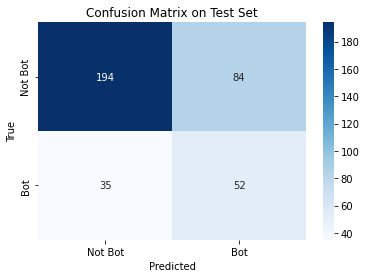

In [ ]:
# Calculate the confusion matrix for the test set predictions
cm = confusion_matrix(all_true_labels, all_predictions, labels=[0, 1])

# Visualize the confusion matrix using a heatmap for clarity
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Bot", "Bot"], yticklabels=["Not Bot", "Bot"])

# Label the axes and add a title for the plot
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.show()
